# Hyperparameter Tuning for Random Forest Classifier (One vs. All)

In [23]:
# import libraries
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_theme(style="whitegrid")

In [2]:
# import data
df = pd.read_csv('data/tracks_1000+.csv', index_col=False)
df.drop(columns={'Unnamed: 0'}, inplace=True)

In [3]:
del df["track_id"]; del df["artist_name"]; del df["track_name"]

In [4]:
# Make it 1000 for each category
result = df.groupby("genre").apply(lambda x: x.head(1000)).reset_index(drop=True)
result

,popularity,genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,86,blues,0.743,0.446,4,-7.807,0,0.0683,0.00390,0.1180,0.3370,0.2780,123.596,232107,4
1,86,blues,0.743,0.446,4,-7.807,0,0.0683,0.00390,0.1180,0.3370,0.2780,123.596,232107,4
2,86,blues,0.743,0.446,4,-7.807,0,0.0683,0.00390,0.1180,0.3370,0.2780,123.596,232107,4
3,80,blues,0.636,0.676,2,-3.442,1,0.0263,0.08070,0.0000,0.0831,0.2730,113.980,208760,4
4,80,blues,0.636,0.676,2,-3.442,1,0.0263,0.08070,0.0000,0.0831,0.2730,113.980,208760,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,37,techno,0.714,0.621,9,-7.005,1,0.0893,0.20100,0.0192,0.0568,0.7450,114.237,331040,4
9996,34,techno,0.803,0.960,9,-3.342,0,0.0429,0.01570,0.0242,0.0566,0.5470,125.990,231271,4
9997,49,techno,0.880,0.477,0,-10.947,1,0.0732,0.00143,0.6270,0.0922,0.2090,125.017,539520,4
9998,47,techno,0.626,0.665,7,-10.134,0,0.0574,0.00775,0.7560,0.0811,0.0327,125.009,240000,4


## Training Preparation & Scaling

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

y_tmp = pd.DataFrame(result["genre"])
X = result.drop("genre", axis=1)
encoder = OneHotEncoder(sparse=False)
encoder.fit(y_tmp)
cols = [x.replace("x0_", "") for x in encoder.get_feature_names()]
display(len(cols))
y = pd.DataFrame(encoder.transform(y_tmp), columns=cols)
X_train_org, X_test_org, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)# , stratify=y > 0

10

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

def scaler_pipeline():
    return make_pipeline(SimpleImputer(strategy='constant', fill_value=0), RobustScaler())

def scaler_pipeline_pwr():
    return make_pipeline(SimpleImputer(strategy='constant', fill_value=0), RobustScaler(), PowerTransformer(method='yeo-johnson', standardize=True))

ct = ColumnTransformer([
        ('stdscaled', StandardScaler(), ["popularity","danceability","energy","key","loudness","mode","speechiness","acousticness","instrumentalness","liveness","valence","tempo","duration_ms","time_signature"]),
       ], remainder='passthrough')

X_train_scaled = ct.fit_transform(X_train_org)
X_test_scaled  = ct.transform(X_test_org)
X_train = X_train_scaled
X_test  = X_test_scaled

## Examine Parameters and Influences

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

### Number of Trees in Forest

In [8]:
n_trees = [10, 50, 100, 500, 1000]
cv_scores = {
    'genre': [],
    'n_trees': [],
    'score': []
}

for gen in y_train.columns:
    print('Genre:\t', gen)
    for n_estimator in n_trees:
        _model = RandomForestClassifier(n_estimator)
        _model.fit(X_train, y_train[gen])
        cv = cross_val_score(_model, X_train, y_train[gen], cv=3, scoring='accuracy')
        print('Cross validation score for {} estimator -> \t {}'.format(n_estimator, cv))
        cv_scores['genre'].append(gen)
        cv_scores['n_trees'].append(n_estimator)
        cv_scores['score'].append(cv)
    print('')

cv_scores_df = pd.DataFrame.from_dict(cv_scores)

Genre:	 blues
Cross validation score for 10 estimator -> 	 [0.8920135  0.8976378  0.90172543]
Cross validation score for 50 estimator -> 	 [0.89576303 0.90438695 0.90285071]
Cross validation score for 100 estimator -> 	 [0.89913761 0.90438695 0.90172543]
Cross validation score for 500 estimator -> 	 [0.89876265 0.90288714 0.90097524]
Cross validation score for 1000 estimator -> 	 [0.90101237 0.90138733 0.89947487]

Genre:	 classical
Cross validation score for 10 estimator -> 	 [0.98687664 0.98612673 0.98687172]
Cross validation score for 50 estimator -> 	 [0.98950131 0.99025122 0.98949737]
Cross validation score for 100 estimator -> 	 [0.99062617 0.98875141 0.99024756]
Cross validation score for 500 estimator -> 	 [0.99025122 0.99025122 0.98949737]
Cross validation score for 1000 estimator -> 	 [0.99100112 0.98912636 0.98987247]

Genre:	 electronic
Cross validation score for 10 estimator -> 	 [0.9096363  0.91338583 0.90660165]
Cross validation score for 50 estimator -> 	 [0.91301087 0.

In [9]:
def plot_validations(cv_scores, x_label, x_ticklabels, genre):
    plt.figure(figsize=(len(x_ticklabels),4))
    plt.title(genre)
    ax = sns.boxplot(data=cv_scores)
    ax.set_xticklabels(x_ticklabels)
    ax.set_ylabel('accuracy')
    ax.set_xlabel(x_label);

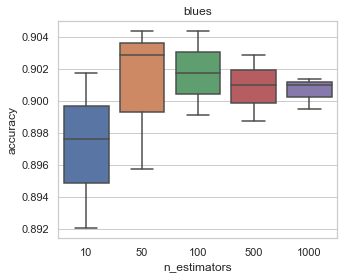

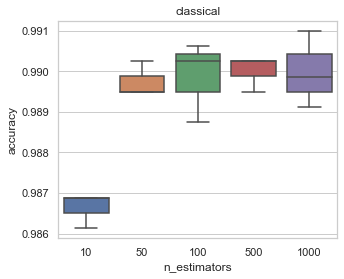

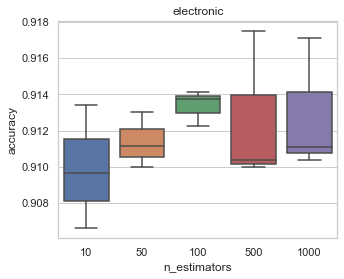

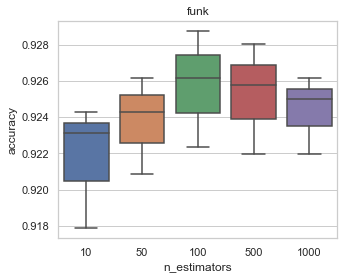

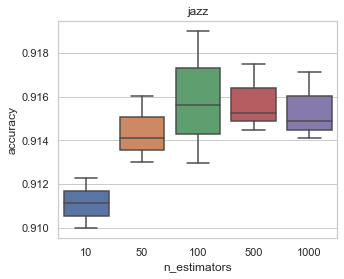

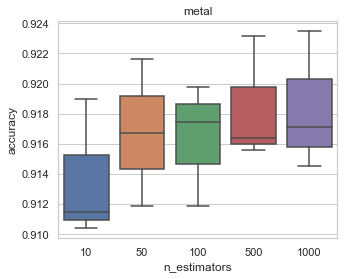

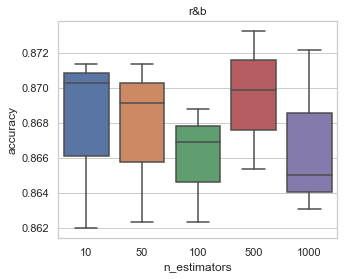

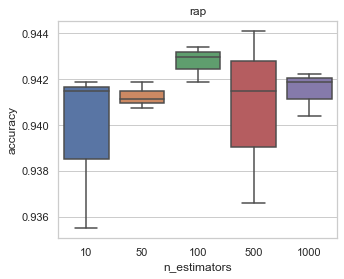

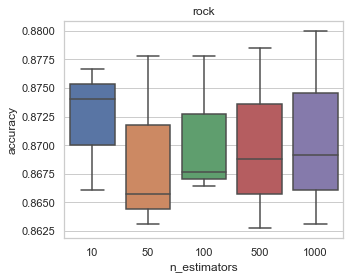

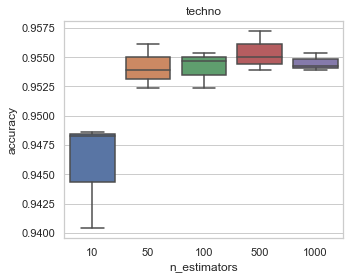

In [10]:
for genre in y_train.columns:
    plot_validations(cv_scores_df[cv_scores_df['genre']==genre]['score'].tolist(), 'n_estimators', n_trees, genre)

### Max Tree Depth

In [11]:
max_depths = range(1,8)

cv_scores_max_depth = {
    'genre': [],
    'tree_depth': [],
    'score': []
}

for genre in y_train.columns:
    print('Genre:\t', genre)
    for depth in max_depths:
        _model = RandomForestClassifier(max_depth=depth)
        _model.fit(X_train, y_train[genre])
        cv = cross_val_score(_model, X_train, y_train[genre], cv=3, scoring='accuracy')
        print('Cross validation score for max tree depth of {} -> \t {}'.format(depth, cv))
        cv_scores_max_depth['genre'].append(genre)
        cv_scores_max_depth['tree_depth'].append(depth)
        cv_scores_max_depth['score'].append(cv)
    print('')

cv_scores_max_depth_df = pd.DataFrame.from_dict(cv_scores_max_depth)

Genre:	 blues
Cross validation score for max tree depth of 1 -> 	 [0.90101237 0.90101237 0.90097524]
Cross validation score for max tree depth of 2 -> 	 [0.90101237 0.90101237 0.90097524]
Cross validation score for max tree depth of 3 -> 	 [0.90101237 0.90101237 0.90097524]
Cross validation score for max tree depth of 4 -> 	 [0.90101237 0.90101237 0.90097524]
Cross validation score for max tree depth of 5 -> 	 [0.90101237 0.90101237 0.90097524]
Cross validation score for max tree depth of 6 -> 	 [0.90101237 0.90101237 0.90097524]
Cross validation score for max tree depth of 7 -> 	 [0.90026247 0.90101237 0.90097524]

Genre:	 classical
Cross validation score for max tree depth of 1 -> 	 [0.96362955 0.95125609 0.93773443]
Cross validation score for max tree depth of 2 -> 	 [0.97525309 0.96925384 0.97299325]
Cross validation score for max tree depth of 3 -> 	 [0.9823772  0.97862767 0.98312078]
Cross validation score for max tree depth of 4 -> 	 [0.98500187 0.98537683 0.98837209]
Cross vali

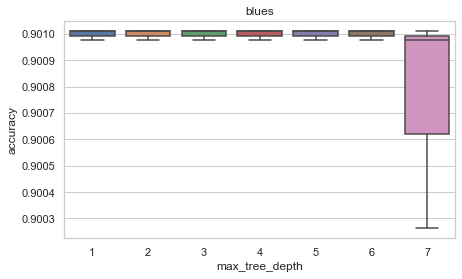

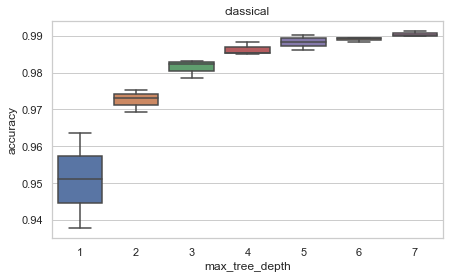

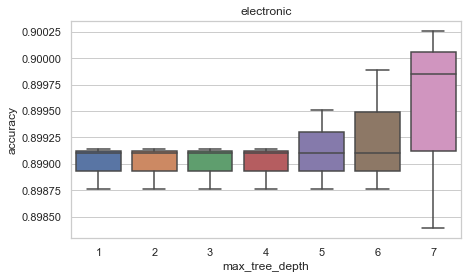

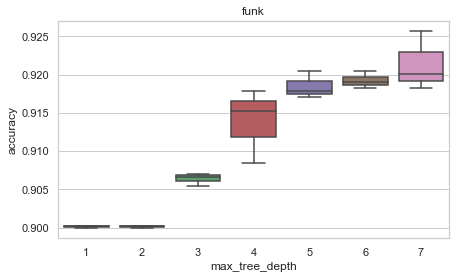

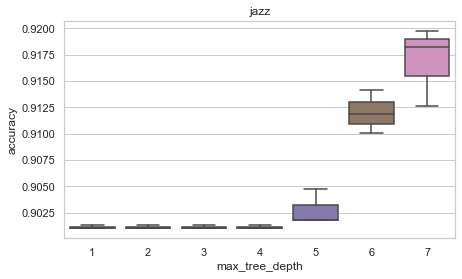

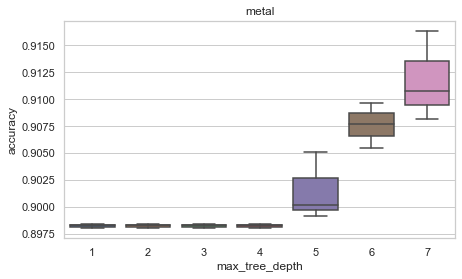

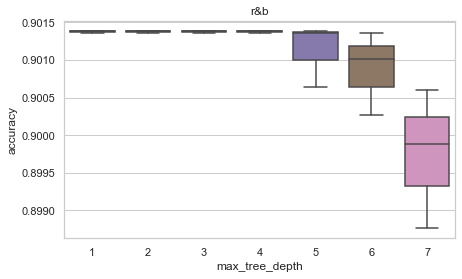

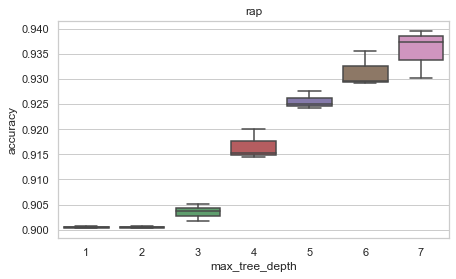

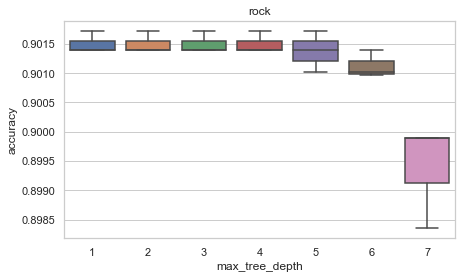

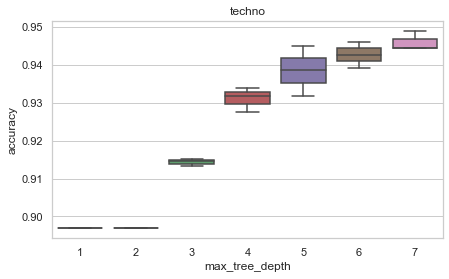

In [12]:
for genre in y_train.columns:
    plot_validations(cv_scores_max_depth_df[cv_scores_max_depth_df['genre']==genre]['score'].tolist(), 'max_tree_depth', max_depths, genre)

### Max Features in Model

In [13]:
n_max_features = range(1, X.shape[1])
cv_scores_max_features = {
    'genre': [],
    'n_features': [],
    'score': []
}

for genre in y_train.columns:
    print('Genre:\t', genre)
    for n_features in n_max_features:
        _model = RandomForestClassifier(max_features=n_features)
        _model.fit(X_train, y_train[genre])
        cv = cross_val_score(_model, X_train, y_train[genre], cv=3, scoring='accuracy')
        print('Cross validation score for max number of features {} -> \t {}'.format(n_features, cv))
        cv_scores_max_features['genre'].append(genre)
        cv_scores_max_features['n_features'].append(n_features)
        cv_scores_max_features['score'].append(cv)

cv_scores_max_features_df = pd.DataFrame.from_dict(cv_scores_max_features)

Genre:	 blues
Cross validation score for max number of features 1 -> 	 [0.89088864 0.89613798 0.89534884]
Cross validation score for max number of features 2 -> 	 [0.89651294 0.90363705 0.89984996]
Cross validation score for max number of features 3 -> 	 [0.89801275 0.90101237 0.90060015]
Cross validation score for max number of features 4 -> 	 [0.89801275 0.90438695 0.89984996]
Cross validation score for max number of features 5 -> 	 [0.89988751 0.90813648 0.90510128]
Cross validation score for max number of features 6 -> 	 [0.89913761 0.90851144 0.90622656]
Cross validation score for max number of features 7 -> 	 [0.90288714 0.91001125 0.90585146]
Cross validation score for max number of features 8 -> 	 [0.9047619  0.90663667 0.90810203]
Cross validation score for max number of features 9 -> 	 [0.90026247 0.90701162 0.90285071]
Cross validation score for max number of features 10 -> 	 [0.90213723 0.90776153 0.90697674]
Cross validation score for max number of features 11 -> 	 [0.8983

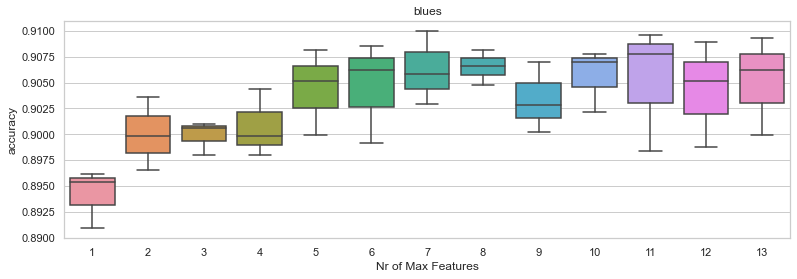

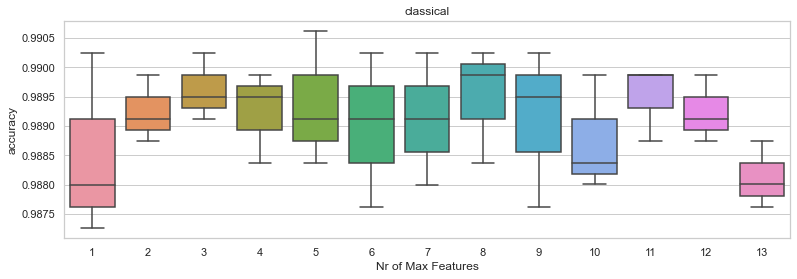

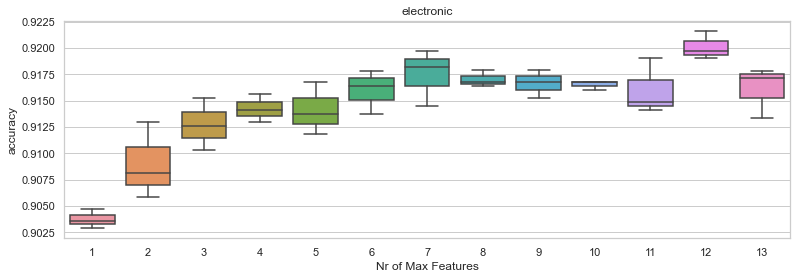

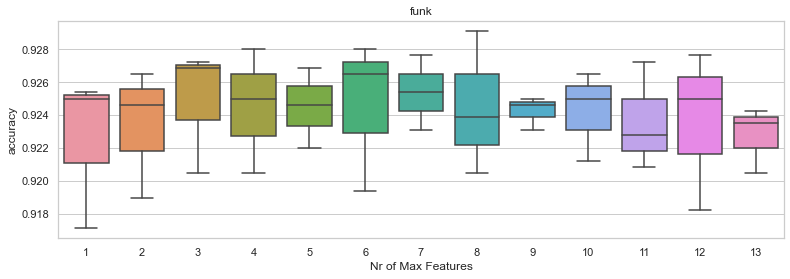

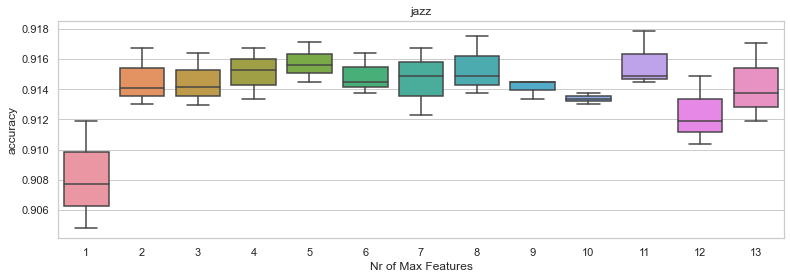

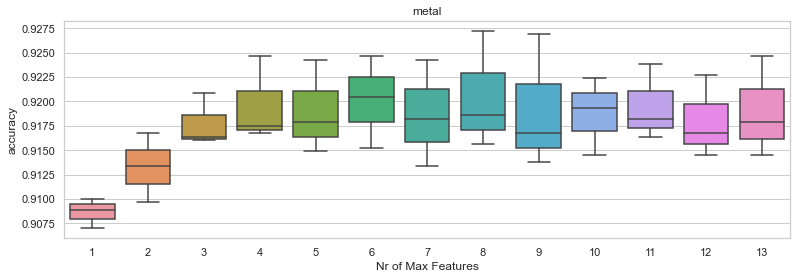

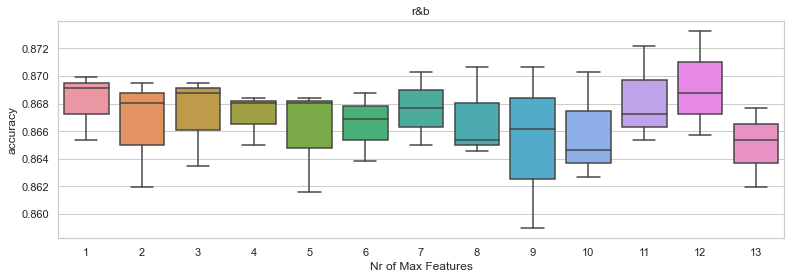

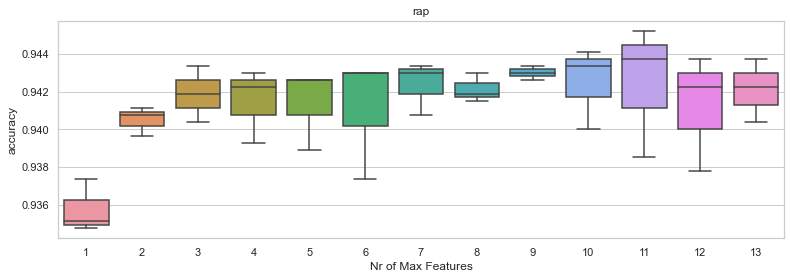

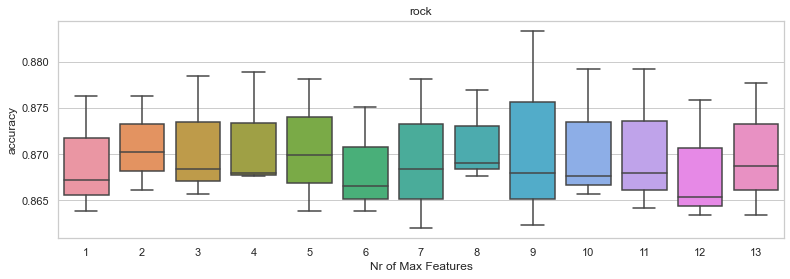

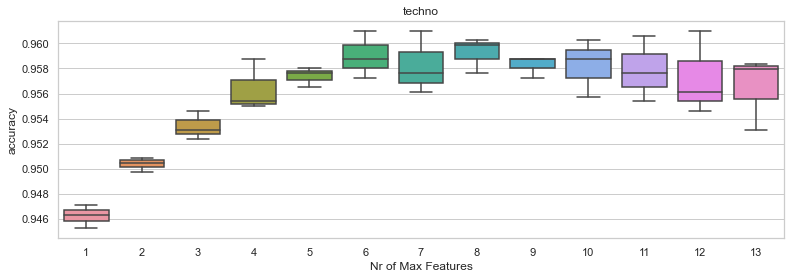

In [14]:
for genre in y_train.columns:
    plot_validations(cv_scores_max_features_df[cv_scores_max_features_df['genre']==genre]['score'].tolist(), 'Nr of Max Features', n_max_features, genre)

- Each genre has slight different cross validation scores based on the number of maximum features.
- Mostly number of features greater than 7 or 8 doesn't show a huge improvement.
- In general, there is a performance gap of ~2% between the best and worst. Ultimately changing the number of features don't make drastic changes.

### Optimize parameters of random forest classifier with RandomSearch

In [18]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

In [21]:
rfc = RandomForestClassifier() # model to be optimized

# parameters to be optimized
params_grid = {
    'n_estimators': n_trees,
    'max_features': n_max_features,
    'max_depth': max_depths
}

# tuning parameters
n_iter = 100
cv = KFold(3, random_state=42, shuffle=True)
n_jobs = -1
scoring = 'accuracy'

In [26]:
random_search = RandomizedSearchCV(rfc, params_grid, n_iter=n_iter, cv=cv, n_jobs=n_jobs, scoring=scoring, random_state=42, verbose=3)
rfc_randomized_search = {
    'genre': [],
    'test-accuracy': []
}

start = time.time()
for genre in y_train.columns:
    print('Randomized Search for:\t ', genre)
    loop_start = time.time()
    _model = RandomForestClassifier()
    _random_search = RandomizedSearchCV(_model, params_grid, n_iter=n_iter, cv=cv, n_jobs=n_jobs, scoring=scoring, random_state=42, verbose=3)
    _random_search.fit(X_train, y_train[genre])
    _predictions = _random_search.best_estimator_.predict(X_test)
    _test_accuracy = round(accuracy_score(y_test[genre], _predictions), 4) * 100
    rfc_randomized_search['genre'].append(genre)
    rfc_randomized_search['test-accuracy'].append(_test_accuracy)
    print(f'Test set Accuracy:\t {_test_accuracy}%.')
    loop_duration = round(time.time() - loop_start)
    print('Genre:\t', genre, '\nComputation time:\t', loop_duration, ' seconds')

end = round(time.time() - start)
print('##########################################')
print('Total process duration:\t', end, ' seconds')

Randomized Search for:	  blues
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Test set Accuracy:	 90.10000000000001%.
Genre:	 blues 
Computation time:	 80.66628193855286  seconds
Randomized Search for:	  classical
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Test set Accuracy:	 98.65%.
Genre:	 classical 
Computation time:	 61.30264091491699  seconds
Randomized Search for:	  electronic
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Test set Accuracy:	 91.4%.
Genre:	 electronic 
Computation time:	 62.50833296775818  seconds
Randomized Search for:	  funk
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Test set Accuracy:	 91.3%.
Genre:	 funk 
Computation time:	 62.787232637405396  seconds
Randomized Search for:	  jazz
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Test set Accuracy:	 91.3%.
Genre:	 jazz 
Computation time:	 73.32329106330872  seconds
Randomized Search for:	  metal
Fitting 3 folds for each of 10

In [28]:
rfc_randomized_search_df = pd.DataFrame.from_dict(rfc_randomized_search)
rfc_randomized_search_df.sort_values(by='test-accuracy', ascending=False)

,genre,test-accuracy
1,classical,98.65
9,techno,96.05
7,rap,93.65
5,metal,93.15
2,electronic,91.40
3,funk,91.30
4,jazz,91.30
0,blues,90.10
6,r&b,89.45
8,rock,89.40
